In [2]:
import sys, os, time
import numpy as np
from tqdm import tqdm_notebook as tqdm
%matplotlib notebook
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
# from foundation import util, models, train
from argparse import Namespace

In [6]:
args = Namespace()

args.dim = 300
args.device = 'cpu'

args.batch_size = 128
args.num_workers = 4
args.val_per = 0.1

args.lr = 1e-2
args.weight_decay = 1e-3

args.loss_type = 'mse'

In [7]:
class Predict_Relations(Dataset):
    def __init__(self, path='../../fast_table.pth.tar'):
        super().__init__()
        
        data = torch.load(path)
        
        self.tuples = data['rows']
        self.table = dict(zip(data['elements'], data['vecs']))
        
    def convert(self, word):
        return torch.from_numpy(self.table[word])
        
    def __len__(self):
        return len(self.tuples)
    
    def __getitem__(self, idx):
        sub, rel, obj = self.tuples[idx]
        
        x = torch.cat([self.convert(sub), self.convert(obj)],-1)
        y = self.convert(rel)
        
        return x,y
        
dataset = Predict_Relations()
len(dataset)

FileNotFoundError: [Errno 2] No such file or directory: '../../fast_table.pth.tar'

In [8]:
#model = models.make_MLP(args.dim*2, args.dim, hidden_dims=[512], nonlin='prelu')
nonlin = nn.PReLU
model = nn.Sequential(
    nn.Linear(args.dim*2, 512),
    nonlin(),
    nn.Linear(512, args.dim),
)
args.epoch = 0
model.to(args.device)
print(model)

Sequential(
  (0): Linear(in_features=600, out_features=512, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=512, out_features=300, bias=True)
)


In [9]:
def iterate(mode, model, dataloader, print_freq=None, ret_dists=False):
    if mode == 'train':
        model.train()
        torch.set_grad_enabled(True)
    else:
        model.eval()
        torch.set_grad_enabled(False)
    
    loader = tqdm(enumerate(dataloader),total=len(dataloader))
    
#     if print_freq is None:
#         print_freq = len(loader) // 100
        
    if not ret_dists:
        stats = util.StatsMeter(tau=20/len(dataloader))
        stats.new('loss')
        
    dists = []
        
    for i, (x,y) in loader:
        
        x, y = x.to(args.device), y.to(args.device)
        
        pred = model(x)
        
        if args.loss_type == 'cos':
            loss = criterion(pred, y, torch.tensor(1.).to(args.device))
        else:
            loss = criterion(pred, y).mean(-1)
        
        if ret_dists:
            dists.append(loss.detach())
        
        loss = loss.mean()
        
        if mode == 'train':
            optim.zero_grad()
            loss.backward()
            optim.step()
        
        if not ret_dists:
        
            stats.update('loss', loss)

            loader.set_description("loss: {:.4f}".format(stats['loss'].smooth.item()))
        
        else:
            loader.set_description("loss: {:.4f}".format(loss.item()))
    
    del loader
    
    torch.set_grad_enabled(True)
    
    if ret_dists:
        return torch.cat(dists).cpu()
    
    return stats

In [10]:
##############################3
# Train Model
###############################
traindata, valdata = train.split_dataset(dataset,shuffle=True, split1=1-args.val_per)
len(traindata), len(valdata)
trainloader, valloader = DataLoader(traindata, num_workers=args.num_workers, batch_size=args.batch_size, shuffle=True), \
                        DataLoader(valdata, num_workers=args.num_workers, batch_size=args.batch_size, shuffle=False)
len(trainloader), len(valloader)

NameError: name 'train' is not defined

In [24]:
optim = util.get_optimizer('adam', model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
if args.loss_type == 'cos':
    criterion = nn.CosineEmbeddingLoss(reduction='none')
else:
    criterion = nn.MSELoss(reduction='none')

In [26]:
for e in range(1):
    train_stats = iterate('train', model, trainloader)
    
    val_stats = iterate('val', model, valloader)
    
    print('Epoch {} results: Train: {:.4f} Val: {:.4f}'.format(args.epoch+1,train_stats['loss'].avg.item(), val_stats['loss'].avg.item()))
    
    args.epoch += 1

A Jupyter Widget

/home/fleeb/workspace/marl/foundation/foundation/util/stats.py:288: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.val = torch.tensor(val).float()


A Jupyter Widget


Epoch 1 results: Train: 0.0273 Val: 0.0269


In [5]:
# torch.save({
#     'args': args,
#     'model_state_dict': model.state_dict(), 
# }, 'consistency.pth.tar')

In [12]:
##########################
# Load pretrained model
##########################

checkpoint = torch.load('consis_model.pth.tar', map_location='cpu')
args = checkpoint['args']

if args.loss_type == 'cos':
    criterion = nn.CosineEmbeddingLoss(reduction='none')
else:
    criterion = nn.MSELoss(reduction='none')

model.load_state_dict(checkpoint['model_state_dict'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [13]:
path = '../../oie_table.pth.tar'
testset = Predict_Relations(path)
len(testset)

FileNotFoundError: [Errno 2] No such file or directory: '../../oie_table.pth.tar'

In [25]:
testloader = DataLoader(testset, num_workers=args.num_workers, batch_size=256, shuffle=False)
len(testloader)

15

In [26]:
losses = iterate('test', model, testloader, ret_dists=True)
len(losses)

A Jupyter Widget

3793

In [28]:
# torch.save(losses, 'oie_consis.pth.tar')

<IPython.core.display.Javascript object>


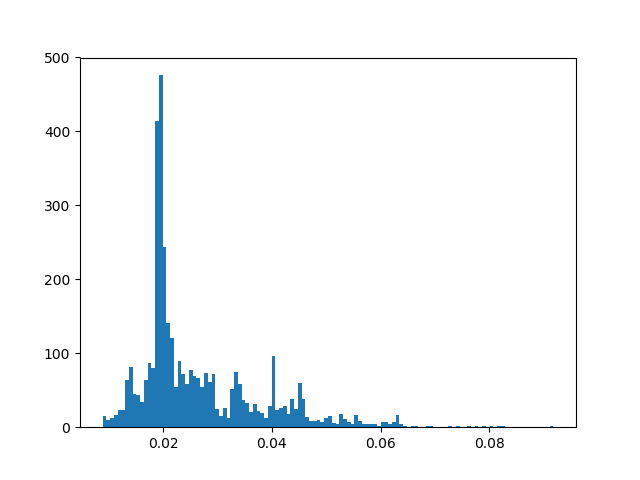

In [27]:
plt.hist(losses.numpy(), bins=120)
pass

In [19]:
idx = losses.argsort().numpy()
options = np.array(testset.tuples)

In [20]:
k = 100

In [21]:
print('top {}'.format(k))
for o in options[idx[:k]]:
    print('{:<15} {:<15} {:<15}'.format(*o))

top 100
predators       have            difficulty     
landfills       have            negative impact
landfills       have            negative impact
landfills       have            impact         
landfills       have            impact         
landfills       have            negative impact on environment
landfills       have            negative impact on communities
landfills       have            impact on environment
something changes color have            color          
animals         have            food source    
landfills       have            impact on communities
something changes color have            same color     
people          have            reactions      
animals         have            same food source
two animals     have            food source    
two objects     have            same charge    
objects         have            same charge    
types           have            role           
two animals     have            same food source
types           have

In [22]:
print('bottom {}'.format(k))
for o in options[idx[-k:]]:
    print('{:<15} {:<15} {:<15}'.format(*o))

bottom 100
winter solstice is on           December 21st  
tree            planting        new tree       
ruler           measuring       length         
driving         crash           their car      
water           nutrients to    other parts    
Earth           occurs at_time  13 times       
Earth           is planet       third          
water           nutrients to    other parts of plant
Earth           occurs at_time  13 times per year
Earth           is planet       third closest to Sun
Earth           is planet       third closest  
water           nutrients to    parts of plant 
Pluto           is planet       ninth          
object 's temperature moving to       place          
water           nutrients to    parts          
object 's temperature moving to       warm place     
ruler           measuring       length of object
skeletal system protects        internal organs
system          protects        internal organs
organism        passes          genetic information
